In [8]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

import pandas as pd
import plotly.graph_objects as go

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output


In [2]:
# url from the Covid-19 data is extracted
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"

In [102]:
def prep_fitting_data(df,countries: list):
    new = df[df.location.isin(countries)]
    table = pd.pivot_table(new, values='new_cases_smoothed', index=['date'],
                        columns=['location'], fill_value=0)
    return table

In [3]:
def get_data(url):
    
    """
    Reads CSV data COVID-19 data of different counties from the url  
    
    INPUT: URL of the CSV
    OUTPUT: Pandas dataframe

    """
    
    url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
    covid_data = pd.read_csv(url,sep=",")
    print(f"The number of unique countries in the data are {len(covid_data['location'].unique())}")
    
    return covid_data
    

In [96]:
def clean_data(df):
    """
    Takes in the dataframe and
    - removes unnecessary columns
    - fills the NaN values with zeroes [Assumption: NaN means there were no cases that day instead of filling it with mean values] 
    - correcting the datetime format
    
    INPUT: Pandas dataframe
    OUTPUT: Cleaned dataframe

    """
    cases = df[['date','location','new_cases_smoothed','total_cases', 'total_deaths', 'new_deaths_smoothed']]
    cases = cases.fillna(0)
    
    # converting date object into datetime
    cases["date"]= pd.to_datetime(cases["date"])
    
    # reseting the index
    cases = cases.reset_index(drop = True)
    cases['new_cases_smoothed'] = cases['new_cases_smoothed'].apply(np.ceil)
    
    loc = "E:/uni/Data_Science_E/Data_Science_Enterprise/data/final_cases.csv"
    # saving the dataset
    cases.to_csv(loc,index=False)
    
    return cases
    

### Dashboard preparation

In [232]:
# url from the Covid-19 data is extracted
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"

covid_data = get_data(url)
cases = clean_data(covid_data)


fig = go.Figure()

app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  Applied Data Science on COVID-19 data

    Goal of the project is to teach data science by applying a cross industry standard process,
    it covers the full walkthrough of: automated data gathering, data transformations,
    filtering and machine learning to approximating the doubling time, and
    (static) deployment of responsive dashboard.

    '''),

    dcc.Markdown('''
    ## Multi-Select Country for visualization
    '''),


    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in cases['location'].unique()],
        value=['Germany','Italy'], # which are pre-selected
        multi=True
    ),

    dcc.Markdown('''
        ## Select other graphs
        '''),


    dcc.Dropdown(
    id='daily_stats',
    options=[
        {'label': 'Daily New Cases', 'value': 'new_cases_smoothed'},
        {'label': 'Daily New Deaths', 'value': 'new_deaths_smoothed'},
        {'label': 'Total Cases', 'value': 'total_cases'},
        {'label': 'Total Deaths', 'value': 'total_deaths'},
    ],
    value='new_cases_smoothed',
    multi=False
    ), 

    dcc.Graph(figure=fig, id='main_window_slope')
])


@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value'),
    Input('daily_stats', 'value')])

def update_figure(country_list,show_stats):

    traces = []
    for each in country_list:

        df_plot=cases[cases['location']==each]


        traces.append(dict(x=df_plot.date,
                                y=df_plot[show_stats],
                                mode='markers+lines',
                                opacity=0.9,
                                name=each
                        )
                )

    return {
            'data': traces,
            'layout': dict (
                width=1280,
                height=720,

                xaxis={'title':'Timeline',
                        'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                      }
        )
    }

if __name__ == '__main__':

    app.run_server(debug=True, use_reloader=False)

The number of unique countries in the data are 244
Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


## SIR Modelling

In [38]:
germany = cases[cases["location"] == "Italy"].total_cases.astype("int64").reset_index(drop=True)
germany[35]

4636

In [39]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics/contact rate
gamma=0.1  # recovery rate



# condition I0+S0+R0=N0
I0=cases[cases["location"] == "Germany"].total_cases.astype("int64").reset_index(drop=True)[35]
S0=N0-I0
R0=0

In [40]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


# Simulative approach to calculate SIR curves

In [41]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\3919566462.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

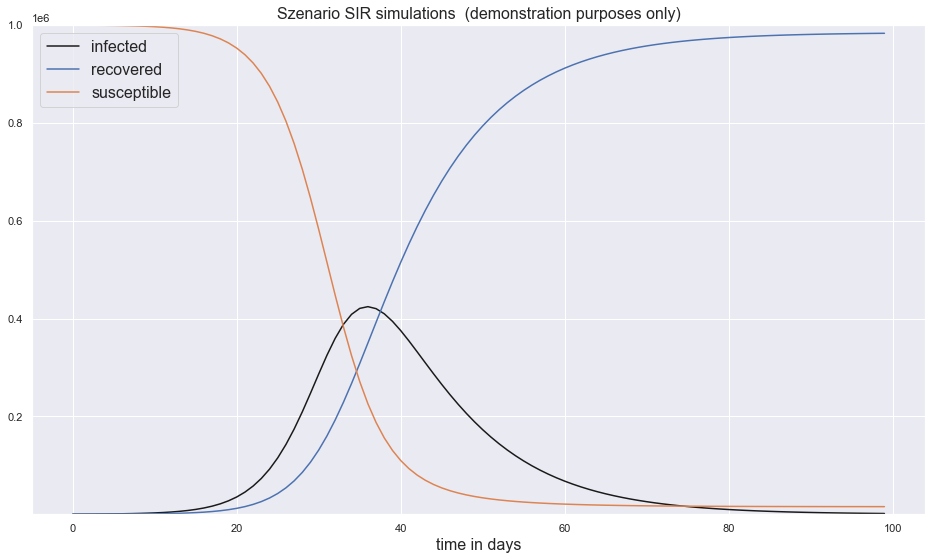

In [42]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

## Fitting the parameters of SIR modelling

In [100]:
countries

['Germany', 'Italy', 'France']

In [107]:
cases = clean_data(covid_data)
table = prep_fitting_data(cases,countries)

In [223]:
ydata = table.Germany[220:320]
t=np.arange(len(ydata))

In [224]:
# ensure re-initialization 
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.2

In [225]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [226]:
def fit_odeint( x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [227]:
# example curve of our differential equationa
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([  1258.        ,   1697.07916587,   2288.78492428,   3085.66002263,
         4157.91858208,   5599.05026174,   7532.92558611,  10122.57406723,
        13580.61195773,  18180.87060372,  24269.96521687,  32276.15271798,
        42710.67085826,  56153.84336732,  73215.15741973,  94455.01709562,
       120259.37991655, 150671.61471392, 185211.23814635, 222740.94788245,
       261461.84287814, 299094.92595199, 333235.38991598, 361777.38238102,
       383262.70659816, 397043.69703628, 403241.27632148, 402560.17988756,
       396052.71398559, 384904.19878091, 370276.2944941 , 353213.24637951,
       334599.11903514, 315149.46336558, 295422.71778589, 275840.79968263,
       256712.31517018, 238254.78995639, 220614.26716201, 203881.75237398,
       188106.58114057, 173307.0494911 , 159478.73941437, 146600.9625778 ,
       134641.70130853, 123561.36600139, 113315.6294482 , 103857.54610731,
        95139.12052703,  87112.45291123,  79730.56127248,  72947.9576901 ,
        66721.0373799 ,  

In [228]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

In [229]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])



standard deviation errors :  [0.00608712 0.00538488]  start infect: 1258
Optimal parameters: beta = 0.23868436929410589  and gamma =  0.1948134289849858


In [230]:
 # get the final fitted curve
fitted=fit_odeint(t, *popt)

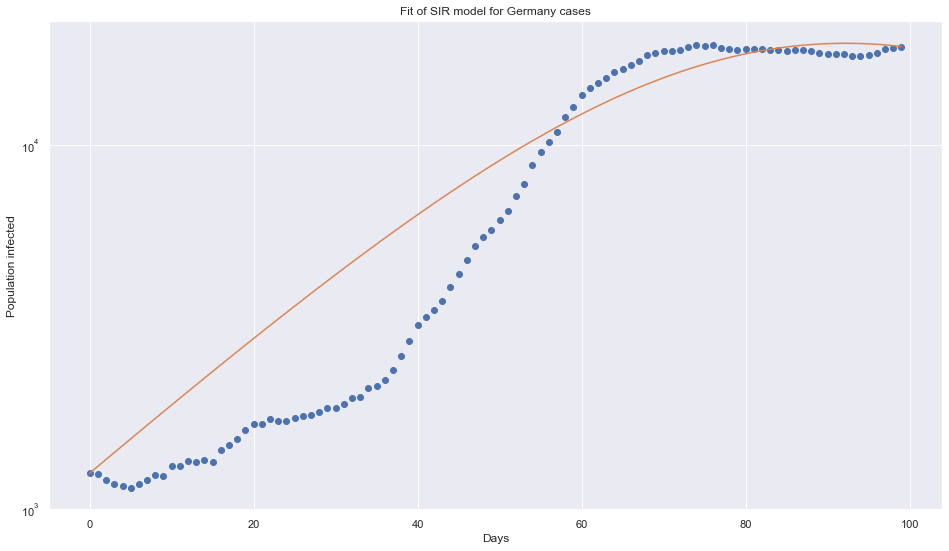

Optimal parameters: beta = 0.23868436929410589  and gamma =  0.1948134289849858
Basic Reproduction Number R0  1.225194641548562
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [231]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

## SIR Dashboard

In [55]:
from jupyter_plotly_dash import JupyterDash
import numpy as np
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
from scipy.integrate import odeint

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\636265646.py:4: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1028\636265646.py:5: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



In [62]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics/contact rate
gamma=0.1  # recovery rate



# condition I0+S0+R0=N0
I0=cases[cases["location"] == "Germany"].total_cases.astype("int64").reset_index(drop=True)[35]
S0=N0-I0
R0=0

In [57]:
ydata = np.array(germany[35:])
t=np.arange(len(ydata))

In [58]:
# ensure re-initialization 
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [59]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [60]:
y0 = S0, I0, R0

In [64]:
def deriv(y, t, Npop, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / Npop
    dIdt = beta * S * I / Npop - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [65]:
ret = odeint(deriv, y0, t, args=(N0, beta, gamma))
S, I, R = ret.T

In [67]:
xp=np.linspace(0, 1,num=99,endpoint=True)
beta=0.2
gamma=0.1

In [79]:
app = dash.Dash()

app.layout = html.Div([
dcc.Graph(
id='Sine wave',
figure={
'data': [
go.Scatter(
x=t,
y=S/N0,
text='Actual point',
mode='lines+markers',
opacity=0.8,
marker={
'size': 2,
'line': {'width': 0.5, 'color': 'blue'}
}
),
go.Scatter(
x=t,
y=I/N0,
text='Actual point',
mode='lines+markers',
opacity=0.8,
marker={
'size': 2,
'line': {'width': 0.5, 'color': 'red'}
}
),
go.Scatter(
x=t,
y=R/N0,
text='Actual point',
mode='lines+markers',
opacity=0.8,
marker={
'size': 2,
'line': {'width': 0.5, 'color': 'green'}
}
)
],
'layout': go.Layout(
xaxis={'type': 'linear', 'title': 'time (days)'},
yaxis=dict(range=[0,1.01],title='S/I/R'),
hovermode='closest'
)
}
),
html.Label('Beta parameter slider'),
dcc.Slider(id='betaslider',min=0,max=1,value=beta,step=0.01,
marks={i/10: {'label': str(i/10), 'style': {'color': 'red'}} for i in range(0, 10)}),
html.Label('Gamma parameter slider'),
dcc.Slider(id='gammaslider',min=0,max=0.25,value=gamma,step=0.01,marks={i/100:str(i/100) for i in range(25)}),
html.Div(id='slider-output-container')
])

@app.callback(
[dash.dependencies.Output('slider-output-container', 'children'),
dash.dependencies.Output('Sine wave', 'figure')],
[dash.dependencies.Input('betaslider', 'value'),dash.dependencies.Input('gammaslider', 'value')])

def update_output(beta,gamma):
    #yp=gammanp.sin(2betanp.pixp) # calculate the new value
    #yq=gammanp.cos(2betanp.pixp)
    ret = odeint(deriv, y0, t, args=(N0, beta, gamma))
    S, I, R = ret.T
    graph= { # update the graph content with the new value
    'data': [
    go.Scatter(
    x=t,
    y=S/N0,
    text='Actual point',
    mode='lines+markers',
    opacity=0.8,
    marker={
    'size': 2,
    'line': {'width': 0.5, 'color': 'blue'}
    }
    ),
    go.Scatter(
    x=t,
    y=I/N0,
    text='Actual point',
    mode='lines+markers',
    opacity=0.8,
    marker={
    'size': 2,
    'line': {'width': 0.5, 'color': 'red'}
    }
    ),
    go.Scatter(
    x=t,
    y=R/N0,
    text='Actual point',
    mode='lines+markers',
    opacity=0.8,
    marker={
    'size': 2,
    'line': {'width': 0.5, 'color': 'green'}
    }
    )
    ],
    'layout': go.Layout(
    xaxis={'type': 'linear', 'title': 'time (days)'},
    yaxis=dict(range=[0,1.01],title='S/I/R'),
    hovermode='closest'
    )
    }
    return [beta,gamma],graph # pass the two outputs in Array

In [81]:
if __name__ == '__main__':

    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
